In [20]:
import os
import sys
import shutil
import glob

import matplotlib.pyplot as plt
%pylab inline

from glue.ligolw import ligolw
from glue.ligolw import table
from glue.ligolw import lsctables
from glue.ligolw import ilwd
from glue.ligolw import utils as ligolw_utils

import pycbc.strain
import pycbc.psd
from pycbc.pnutils import mass1_mass2_to_mchirp_eta
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_two_pol_waveform_filter, get_td_waveform
from pycbc import DYN_RANGE_FAC
from pycbc.types import FrequencySeries, zeros
from pycbc.filter import match, overlap, sigma, make_frequency_series
from pycbc.scheme import CPUScheme, CUDAScheme
from pycbc import pnutils


Populating the interactive namespace from numpy and matplotlib


/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [90]:
from matplotlib import rc
rc('text', usetex=True)

##### Creating .ini file for injections

In [36]:
with open("banksim.ini", 'a') as fout:
    fout.write("""\
[inspinj]
f-lower = 15 
i-distr = fixed
fixed-inc = 0
min-mass1 = 3. 
max-mass1 = 25. 
m-distr = componentMass 
disable-milkyway =
min-mass2 = 3. 
max-mass2 = 25. 
min-distance = 1000  
l-distr = random  
min-mtotal = 6 
waveform = TaylorF2
aligned = 
enable-spin =
;max-mtotal =  
min-spin1 = 0 
max-spin1 = 0 
min-spin2 = 0 
max-spin2 = 0
max-distance = 1000 
d-distr = uniform 
gps-start-time = 1000000000 
gps-end-time =   1000010000
time-interval = 0. 
time-step = 1. 
seed = 3 

[executables]
banksim = /cvmfs/oasis.opensciencegrid.org/ligo/sw/pycbc/x86_64_rhel_7/virtualenv/pycbc-v1.16.10/bin/pycbc_banksim

[workflow]
accounting-group = ligo.dev.o3.cbc.explore.test
log-path = /home/isha.anantpurkar/NonSpinTmplBank/LowMassPaper-BankEffectualness/TaylorT2_EOB_correct/logs/
;use-gpus =
bank-file = LowMass.xml
injections-per-job = 50
templates-per-job = 100 

[banksim]
psd-model = aLIGOZeroDetHighPower 
template-approximant = EOBNRv2 
template-phase-order = 7 
template-amplitude-order = 0 
;template-spin-order =
template-start-frequency = 20
signal-approximant = TaylorF2
signal-phase-order = 7 
signal-amplitude-order = 0 
;signal-spin-order = 0
signal-start-frequency = 20
filter-low-frequency = 20 
filter-sample-rate = 16384
filter-signal-length = 128
mchirp-window = 0.10
""")

In [42]:
! tail -n10 banksim.dag.dagman.out

11/22/20 09:39:01 DAG status: 0 (DAG_STATUS_OK)
11/22/20 09:39:01 Of 636 nodes total:
11/22/20 09:39:01  Done     Pre   Queued    Post   Ready   Un-Ready   Failed
11/22/20 09:39:01   ===     ===      ===     ===     ===        ===      ===
11/22/20 09:39:01   636       0        0       0       0          0        0
11/22/20 09:39:01 0 job proc(s) currently held
11/22/20 09:39:01 DAGMan Runtime Statistics: [ EventCycleTimeAvg = 0.02454903251246402; EventCycleTimeCount = 114.0; EventCycleTimeMax = 0.6963460445404053; EventCycleTimeMin = 5.006790161132812E-05; EventCycleTimeStd = 0.09495264864674624; EventCycleTimeSum = 2.798589706420898; LogProcessCycleTimeAvg = 0.0006954303154578576; LogProcessCycleTimeCount = 26.0; LogProcessCycleTimeMax = 0.001763105392456055; LogProcessCycleTimeMin = 0.0002069473266601562; LogProcessCycleTimeStd = 0.000418127797987908; LogProcessCycleTimeSum = 0.0180811882019043; SleepCycleTimeAvg = 5.004548687683909; SleepCycleTimeCount = 114.0; SleepCycleTimeMax = 

#### Images

In [21]:
from IPython.display import Image

In [43]:
! ls plots

cum_hist.png		 m1-m2-mchirpdiff.png	  q-s2z-match90.png
hist-match-cum.png	 m1-m2-mchirpreldiff.png  q-s2z-match97.png
hist-match.png		 q-s1m-match.png	  q-s2z-match.png
hist-mchirp-diff.png	 q-s1z-match.png	  q-s2z-mchirpdiff.png
hist-mchirp-reldiff.png  q-s1z-mchirpdiff.png	  q-s2z-mchirpreldiff.png
inc-match.png		 q-s1z-mchirpreldiff.png  tm1-tm2-match.png
m1-m2-match.png		 q-s2m-match.png


In [23]:
import numpy as np

In [24]:
bank_filename = 'LowMass.xml'
xml_doc = ligolw_utils.load_filename(bank_filename, contenthandler=table.use_in(ligolw.LIGOLWContentHandler), verbose=True)
sngl_inspiral_table = lsctables.SnglInspiralTable.get_table(xml_doc)

reading 'LowMass.xml' ...
md5sum: 1472c7b9379a769ffab4625b89dee6f3  LowMass.xml


In [25]:
m1 = np.array([sngl_wf.mass1 for sngl_wf in sngl_inspiral_table])
m2 = np.array([sngl_wf.mass2 for sngl_wf in sngl_inspiral_table])

Text(0, 0.5, 'mass 2')

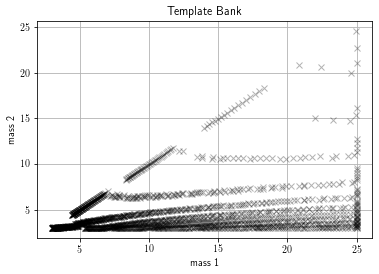

In [26]:
plt.figure()
plt.plot(m1, m2, 'kx', alpha=0.3)
plt.grid()
plt.title("Template Bank")
plt.xlabel('mass 1')
plt.ylabel('mass 2')

In [44]:
res = np.loadtxt("results.dat")
match = res[:,0]

tmass1 = res[:,1]
tmass2 = res[:,2]
tspin1x = res[:,3] 
tspin1y = res[:,4]
tspin1z = res[:,5]
tspin2x = res[:,6]
tspin2y = res[:,7]
tspin2z = res[:,8]
tmchirp, teta = pnutils.mass1_mass2_to_mchirp_eta(tmass1, tmass2)

imass1 = res[:,9]
imass2 = res[:,10]
ispin1x = res[:,11]
ispin1y = res[:,12]
ispin1z = res[:,13]
ispin2x = res[:,14]
ispin2y = res[:,15]
ispin2z = res[:,16]
imchirp, ieta = pnutils.mass1_mass2_to_mchirp_eta(imass1, imass2)

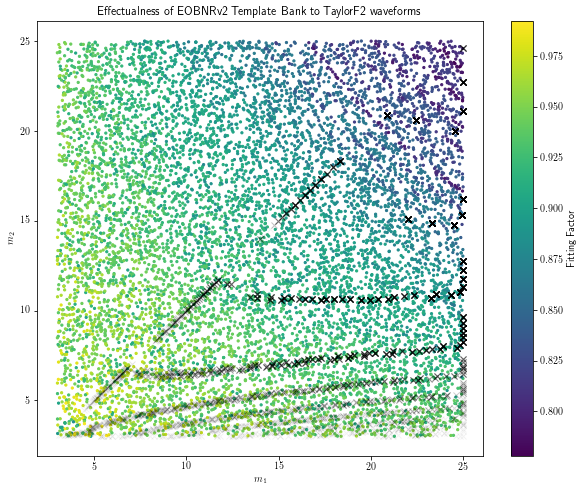

In [101]:
plt.figure(figsize(10,8))
plt.scatter(imass1, imass2,s=5 ,c = match)
plt.plot(tmass1, tmass2, 'kx', alpha=0.05)
plt.colorbar(label="Fitting Factor")
plt.xlabel("$m_1$")
plt.ylabel("$m_2$")
plt.title("Effectualness of EOBNRv2 Template Bank to TaylorF2 waveforms")

plt.savefig("EffectualnessTaylorF2.png")

Text(0, 0.5, '$\\eta$')

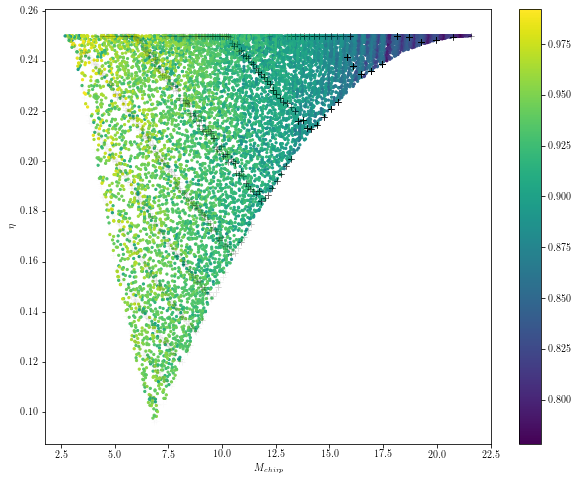

In [96]:
plt.figure(figsize(10,8))
plt.scatter(imchirp, ieta,s=5 ,c = match)
plt.plot(tmchirp, teta, 'k+', alpha=0.01)
#plt.plot(m1, m2, 'kx', alpha=0.3)

plt.colorbar()
plt.xlabel("$M_{chirp}$")
plt.ylabel("$\eta$")

Text(0, 0.5, 'M')

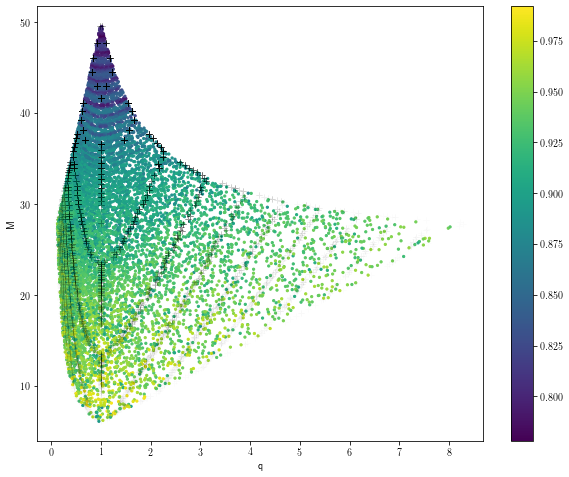

In [98]:
plt.figure(figsize(10,8))
plt.scatter(imass1/imass2, imass1+imass2,s=5 ,c = match)
plt.plot(tmass1/tmass2, tmass1+tmass2, 'k+', alpha=0.01)
plt.plot(tmass2/tmass1, tmass1+tmass2, 'k+', alpha=0.01)
#plt.plot(m1, m2, 'kx', alpha=0.3)

plt.colorbar()
plt.xlabel("q")
plt.ylabel("M")

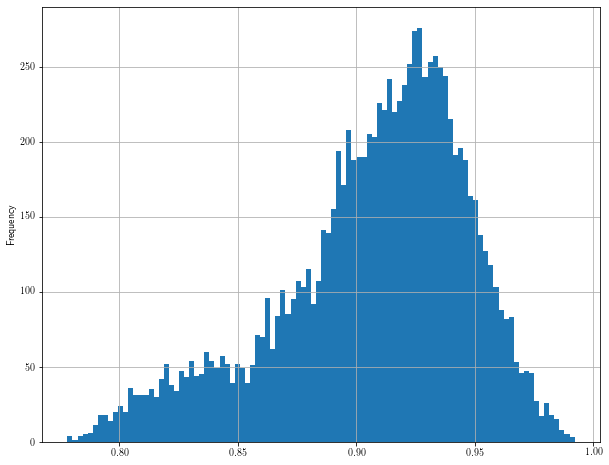

In [80]:
import pandas as pd

match_series = pd.Series(match)
#match_series_norm = match_series.value_counts(normalize=True)
match_series.plot.hist(grid=True, bins=100, rwidth=1)

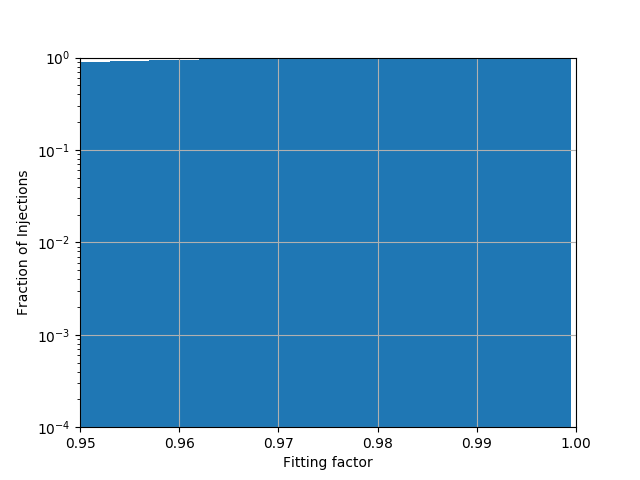

In [50]:
Image('plots/cum_hist.png')

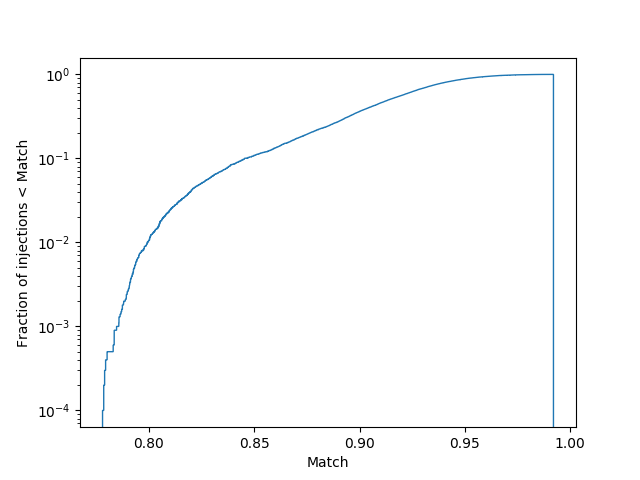

In [77]:
Image('plots/hist-match-cum.png')

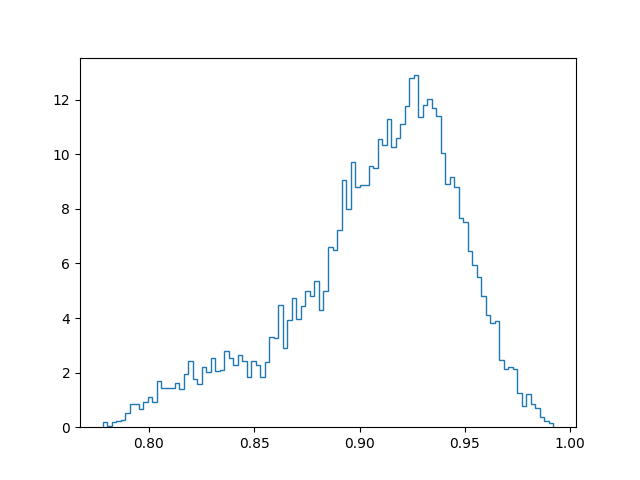

In [79]:
Image('plots/hist-match.png')